In [35]:
import pandas as pd
from pandas import read_csv, DataFrame
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = read_csv('NPAR6.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,alcoholic,biliary,drug_induced,unspecified,mortality_7d,mortality_28d,mortality_90d,mortality_1y,has_kidney_disease,has_sepsis
0,19753686,29945708,30469520,2152-04-07T19:23:59,UNKNOWN,M,50,0,0,4.701343,...,0,1,1,1,0,0,0,0,0,0
1,10442603,23644640,31663173,2125-02-25T15:33:43,UNKNOWN,M,67,1,1,1.110764,...,1,0,0,1,1,1,1,1,0,1
2,15696172,21774504,36542183,2187-02-07T00:52:41,UNKNOWN,M,63,1,1,1.417917,...,0,0,0,1,1,1,1,1,0,1
3,19352969,21921993,34589708,2180-10-06T13:15:00,WHITE,F,67,1,1,1.496956,...,0,1,0,1,1,1,1,1,0,0
4,13734425,25179112,35877842,2132-09-06T09:00:00,WHITE,F,91,1,1,2.088681,...,0,1,0,1,1,1,1,1,0,0


In [37]:
model_linear = smf.glm(formula='mortality_28d ~ NPAR', data=df, family = sm.families.Binomial())
result_linear = model_linear.fit()
result_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          mortality_28d   No. Observations:                  628
Model:                            GLM   Df Residuals:                      626
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -279.94
Date:                Sun, 23 Nov 2025   Deviance:                       559.88
Time:                        10:53:22   Pearson chi2:                     644.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02613
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9496      0.365     -8.090      0.000      -3.664      -2.235
NPAR           0.0452      0.011      4.095      0.000       0.024       0.067
==============================================================================
"""

In [38]:
n_knof = 3
model_spline = smf.glm(formula=f'mortality_28d ~ bs(NPAR, df = {n_knof}, include_intercept = False)', data=df, family=sm.families.Binomial())
result_spline = model_spline.fit()
result_spline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          mortality_28d   No. Observations:                  628
Model:                            GLM   Df Residuals:                      624
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -269.35
Date:                Sun, 23 Nov 2025   Deviance:                       538.71
Time:                        10:53:22   Pearson chi2:                     620.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.05842
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      1.0789      0.984      1.097      0.273      -0.849       3.007
bs(NPAR, df=3, include_intercept=False)[0]    -9.2435      2.311     -4.000      0.000     -13.773      -4.714
bs(NPAR, df=3, include_intercept=False)[1]     4.8399      1.466      3.302      0.001       1.967       7.713
bs(NPAR, df=3, include_intercept=False)[2]    -4.5964      2.176     -2.112      0.035      -8.861      -0.332
==============================================================================================================
"""

In [39]:
LR = 2 * (result_spline.llf - result_linear.llf)
df_diff = result_spline.df_model - result_linear.df_model
p_nonlinear = chi2.sf(LR, df_diff)
p_nonlinear

2.522747887777248e-05

In [40]:
def format_p(p):
    if p < 0.001:
        return 'p<0.001'
    return f'{p:.3f}'

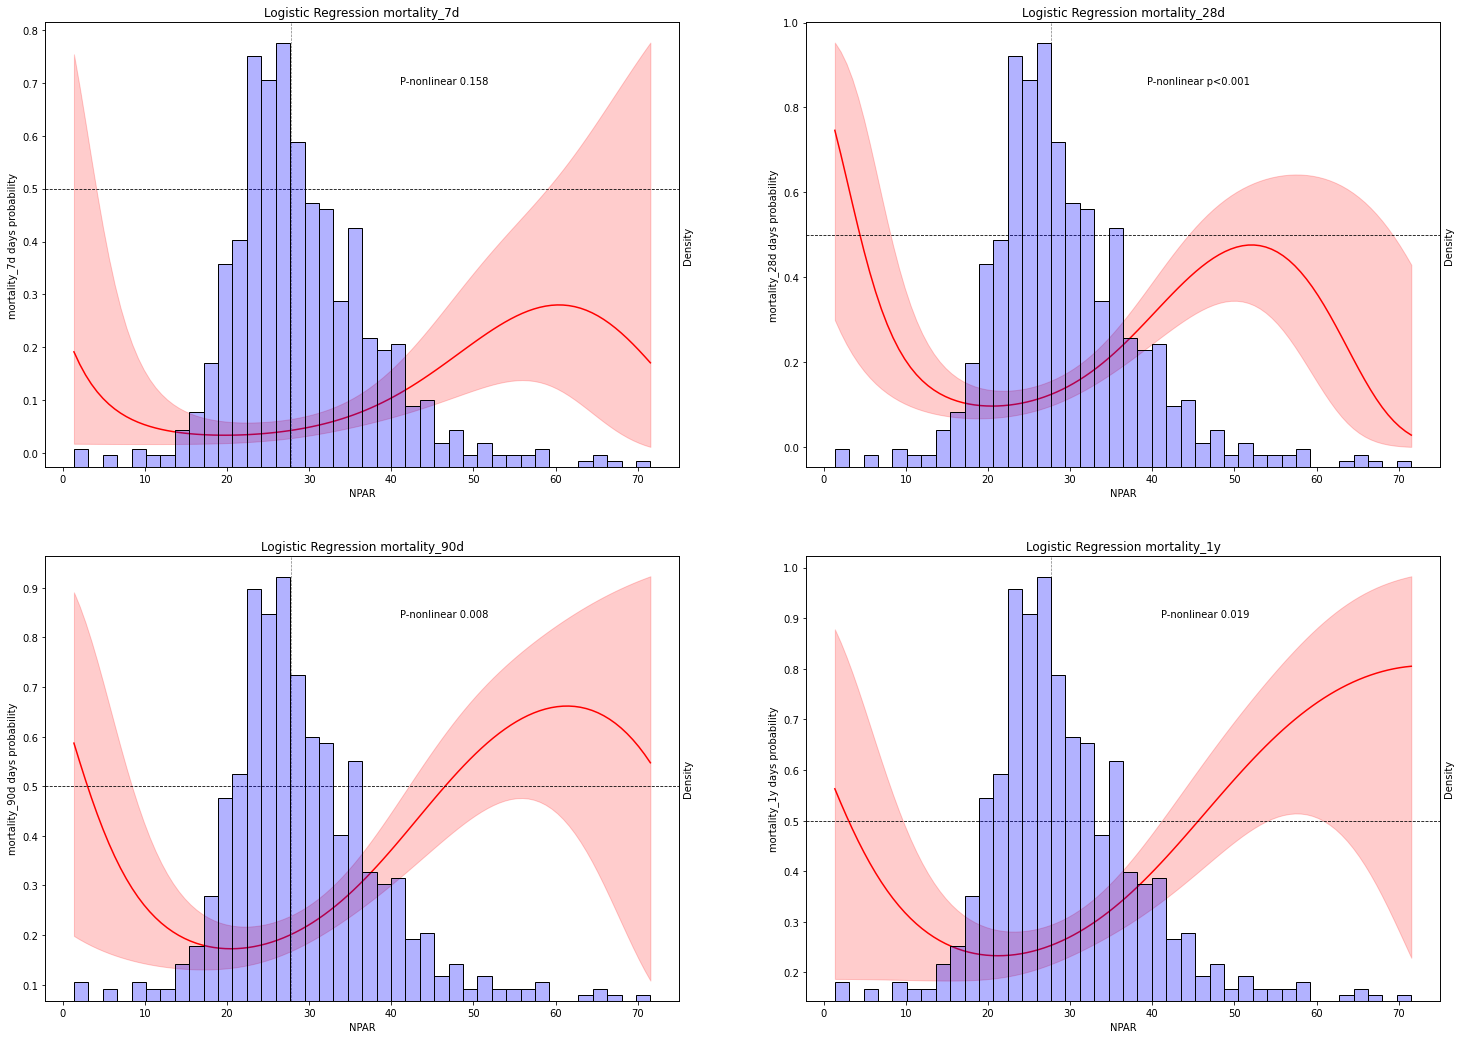

In [44]:
mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(25, 18))
axes = axes.flatten()
n_knof = 3
for i in range(4):
    model_linear = smf.glm(formula = f'{mortalities[i]} ~ NPAR', data=df, family = sm.families.Binomial())
    result_linear = model_linear.fit()
    model_spline = smf.glm(formula = f'{mortalities[i]} ~ bs(NPAR, df = {n_knof}, include_intercept = False)', data=df, family=sm.families.Binomial())
    result_spline = model_spline.fit()
    LR = 2 * (result_spline.llf - result_linear.llf)
    df_diff = result_spline.df_model - result_linear.df_model
    p_nonlinear = chi2.sf(LR, df_diff)

    x_pred = DataFrame(data = {'NPAR': np.linspace(df['NPAR'].min(), df['NPAR'].max(), 100)})
    result_pred = result_spline.get_prediction(x_pred)
    pred_mean = result_pred.predicted_mean
    ci = result_pred.conf_int()
    ax = axes[i]
    ax.plot(x_pred, pred_mean, label="Fitted", color='red')
    ax.fill_between(x_pred['NPAR'].values, ci[:,0], ci[:,1], color='red', alpha=0.2)

    ax.axhline(y=0.5, color='black', linestyle='--', linewidth=0.8)
    
    ax.axvline(x=df["NPAR"].median(), color='gray', linestyle='--', linewidth=0.7)

    # Add histogram
    ax2 = ax.twinx()
    sns.histplot(df["NPAR"], ax=ax2, bins=40, color='blue', alpha=0.3, stat="density")
    ax2.set_yticks([])

    # Set labels
    ax.set_xlabel("NPAR")
    ax.set_ylabel(f"{mortalities[i]} days probability")
    ax.set_title(f"Logistic Regression {mortalities[i]}")
    text = f"P-nonlinear {format_p(p_nonlinear)}"
    ax.text(0.7, 0.88, text, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.show()
